In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from process import load_trace, load_dataset, METRICS_CONFIGS
sns.set_theme()

In [22]:
anomaly = "speculate"
metrics_config = 0
ANOMALY_NAME = "SPECTRE"

In [35]:
dataset = pd.concat(
    [
        load_trace(anomaly, "xFTx.xx", metrics_config)[0],
        load_trace(anomaly, "xKTx.xx", metrics_config)[0],
    ]
).reset_index(drop=True)
dataset

,TIMESTAMP,DURATION,PROBE,KIND,LAYER,CORE,PAIR_ON,PID,L1D_CACHE,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB,LMC0,CONTEXT
0,160748598815,43923.769231,SENS_C1,INTERVAL,PROBE,1,63,0x00003aca,1.784103e+06,432.846154,1042.115385,3338.615385,74.307692,39.576923,0,NOSTRESS
1,160750198310,44024.115385,SENS_C1,INTERVAL,PROBE,1,63,0x00003aca,1.787198e+06,378.961538,968.230769,3019.115385,63.384615,48.269231,0,NOSTRESS
2,160751798321,44157.730769,SENS_C1,INTERVAL,PROBE,1,63,0x00003aca,1.792100e+06,430.923077,1043.461538,3300.423077,103.884615,25.500000,0,NOSTRESS
3,160753398334,44331.269231,SENS_C1,INTERVAL,PROBE,1,63,0x00003aca,1.796918e+06,452.461538,1066.807692,3384.884615,99.576923,29.192308,0,NOSTRESS
4,160754998412,44470.192308,SENS_C1,INTERVAL,PROBE,1,63,0x00003aca,1.801501e+06,434.615385,1037.192308,3296.846154,153.961538,32.192308,0,NOSTRESS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7775,875057786291,100880.115385,SENS_C1,INTERVAL,PROBE,1,63,0x00005f46,2.847796e+06,19802.923077,20488.346154,33021.884615,10814.500000,11.653846,0,SPECTRE
7776,875060413664,100197.423077,SENS_C1,INTERVAL,PROBE,1,63,0x00005f46,2.820371e+06,19709.692308,20387.615385,32649.538462,10766.846154,8.961538,0,SPECTRE
7777,875063023518,98280.692308,SENS_C1,INTERVAL,PROBE,1,63,0x00005f46,2.780209e+06,19394.038462,20075.769231,32174.653846,10596.038462,12.576923,0,SPECTRE
7778,875065583746,96461.692308,SENS_C1,INTERVAL,PROBE,1,63,0x00005f46,2.737360e+06,18886.807692,19558.692308,31341.846154,10299.538462,5.461538,0,SPECTRE


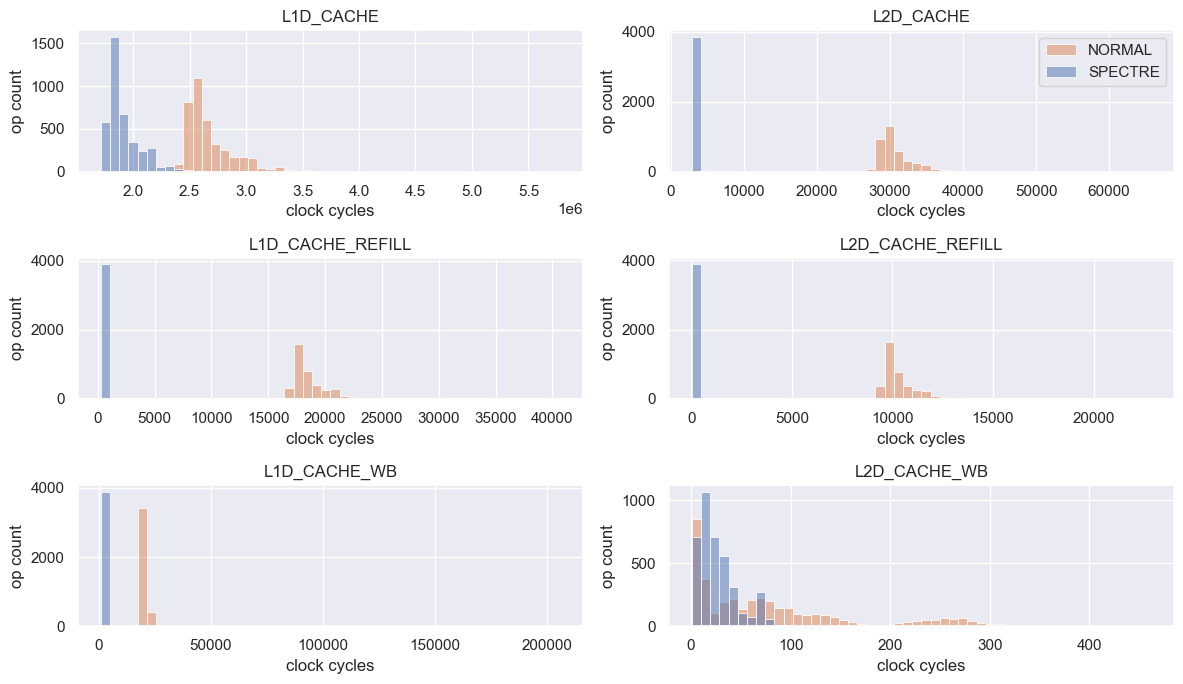

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(12, 7))
for i, o in enumerate(METRICS_CONFIGS[metrics_config]):
    ax = axs[i % 3][i // 3]
    ax.set_title(f"{o}")
    ax.set_xlabel("clock cycles")
    ax.set_ylabel("op count")
    sns.histplot(data=full_data, x=o, bins=50, ax=ax, hue='CONTEXT')
    if i != 3:
        ax.get_legend().remove()
    else:
        ax.legend(["NORMAL", "SPECTRE"])


In [8]:
# predictors = ['BR_PRED']
predictors = ['L1D_CACHE_REFILL', 'L1D_CACHE_WB', 'L2D_CACHE', 'L2D_CACHE_REFILL']

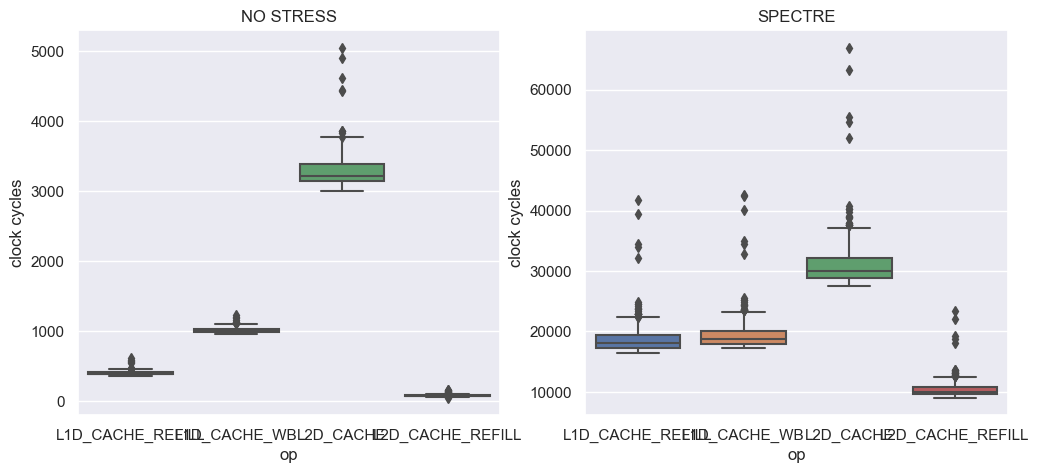

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [16]:
def drop_quantile(df, q=0.025):
    cols = predictors  # one or more

    Q1 = df[cols].quantile(q)
    Q3 = df[cols].quantile(1 - q)
    IQR = Q3 - Q1

    df = df[
        ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    ]
    return df


In [17]:
normal_df = drop_quantile(normal_df)
stress_df = drop_quantile(stress_df)
merged = pd.concat([normal_df, stress_df])
model = KMeans(n_clusters=2)
model.fit(merged[predictors])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [22]:
# Depending on what cluster represents NOSTRESS and what cluster represents SPECULATE,
# we need to swap the labels.
labels = {"NOSTRESS": 0, ANOMALY_NAME: 1}


def test_fn(test_df, model):
    results = model.predict(test_df[predictors])
    y_true = test_df["CONTEXT"].to_numpy()
    y_true = [labels[y] for y in y_true]
    y_pred = results
    print(
        "Accuracy in regime prediction:",
        f"{round(accuracy_score(y_true, y_pred) * 100, 2)}%",
    )


In [23]:
test_fn(merged, model)

Accuracy in regime prediction: 100.0%


# Test xFTJ.xx: intermittent anomaly

In [24]:
test_df, _ = load_trace(anomaly, "xFTJ.xx", metrics_config)
test_df = test_df.reset_index(drop=True)
y_true = test_df["CONTEXT"].iloc[::25]
y_true = y_true.reset_index(drop=True)
test_df = test_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(test_df.index // 25).mean()
test_df["CONTEXT"] = y_true


In [25]:
test_df

,DURATION,L1D_CACHE,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB,CONTEXT
0,42642.44,1736897.08,429.48,1047.480000,3294.920000,67.000000,52.440000,SPECTRE
1,43477.60,1767874.60,360.12,954.200000,2946.560000,34.560000,58.400000,SPECTRE
2,43685.44,1772182.84,358.44,958.640000,2999.800000,94.640000,16.440000,SPECTRE
3,43755.36,1777321.96,401.76,1004.600000,3221.920000,73.840000,28.800000,SPECTRE
4,43938.80,1781912.60,396.84,985.280000,3166.640000,67.920000,25.080000,SPECTRE
...,...,...,...,...,...,...,...,...
4041,50269.80,2032788.40,416.68,1012.280000,3280.560000,120.040000,41.520000,NOSTRESS
4042,49595.20,2005830.60,415.60,1012.640000,3269.000000,127.760000,42.640000,NOSTRESS
4043,48970.84,1981703.60,466.64,1066.880000,3462.600000,139.680000,52.320000,NOSTRESS
4044,48371.32,1958313.92,419.16,1019.760000,3285.680000,127.800000,45.920000,NOSTRESS


In [26]:
normal_df

,DURATION,L1D_CACHE,CONTEXT,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB
0,42255.541667,1.719354e+06,NOSTRESS,433.420833,1073.700000,3417.558333,70.408333,50.991667
1,43129.600000,1.751079e+06,NOSTRESS,367.275000,955.766667,2998.466667,54.741667,63.170833
2,43249.745833,1.755557e+06,NOSTRESS,370.787500,964.025000,3040.416667,93.816667,32.533333
3,43397.812500,1.760648e+06,NOSTRESS,388.820833,983.508333,3117.183333,88.479167,30.875000
4,43513.275000,1.765232e+06,NOSTRESS,380.737500,976.841667,3082.966667,87.395833,28.800000
...,...,...,...,...,...,...,...,...
415,52316.070833,2.117939e+06,NOSTRESS,431.141667,1057.175000,3477.945833,78.587500,25.850000
416,53829.995833,2.181152e+06,NOSTRESS,459.629167,1122.020833,3691.941667,92.366667,29.175000
417,53164.358333,2.155440e+06,NOSTRESS,444.583333,1112.162500,3624.487500,89.750000,29.820833
418,43172.232000,1.757453e+06,NOSTRESS,429.820000,1061.980000,3338.668000,112.116000,42.980000


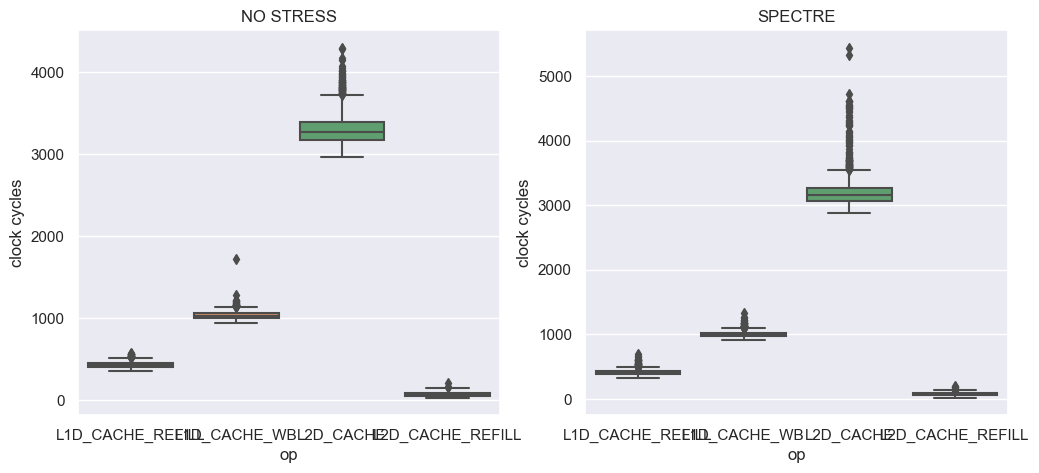

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
normal_df = test_df[test_df["CONTEXT"] == "NOSTRESS"]
stress_df = test_df[test_df["CONTEXT"] == ANOMALY_NAME]
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [28]:
test_fn(test_df, model)

Accuracy in regime prediction: 42.44%


In [ ]:
import pickle

with open(f'models/{anomaly}.pkl', 'wb+') as f:
    pickle.dump({'headers': predictors, 'model': model}, f)